# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from plot_utils import *
%matplotlib inline

from IPython import display
import time

from environments.evil_wgw_env import EvilWindyGridWorld
from tabular_methods import QTable
import os

# Tabular methods (provably converge)

In [2]:
env = EvilWindyGridWorld(grid_size=(7, 10), visual=True, stochasticity=0.01)
num_actions = 4

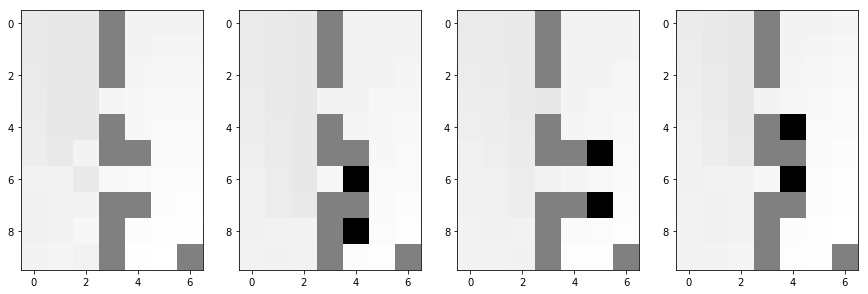

In [3]:
qt = QTable(env)
qt.run_policy_iteration(pol_eval_times=1, tol=1e-5)
qt.plot_q_values()

In [4]:
qt.update_policy()

(1, 9)

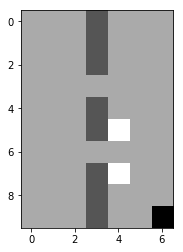

In [5]:
env.play_with_policy(qt.pi)

# Training visualization

In [12]:
for stoc in ["0", "01", "02", "05", "1", "2"]:
    tests = []
    for n in range(1, 6):
        path = "results/031119/quantile/exp"+str(stoc)+"_"+str(n)+"/model/learning_curve.npz"
        test = np.load(path)["test"]
        tests.append(test)
    tests_mean = np.mean(tests, axis=0)
    if not os.path.exists("results/031119/quantile/exp"+str(stoc)+"_0"):
        os.makedirs("results/031119/quantile/exp"+str(stoc)+"_0")
    np.savez("results/031119/quantile/exp"+str(stoc)+"_0/learning_curve.npz", test=tests_mean)

# DQN versus distributional methods

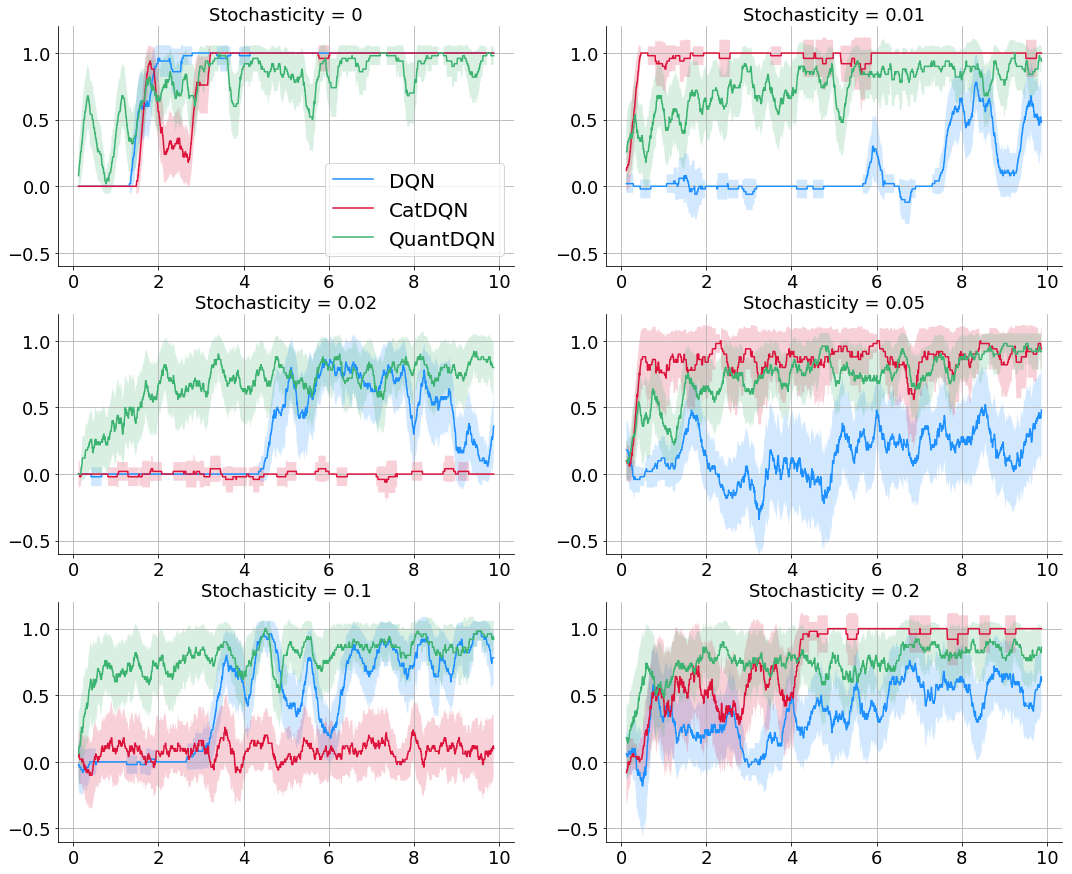

In [7]:
exp_num = 1

paths = [
    "results/031119/exp0_"+str(exp_num)+"/model/learning_curve.npz",
    "results/031119/exp01_"+str(exp_num)+"/model/learning_curve.npz",
    "results/031119/exp02_"+str(exp_num)+"/model/learning_curve.npz",
    "results/031119/exp05_"+str(exp_num)+"/model/learning_curve.npz",
    "results/031119/exp1_"+str(exp_num)+"/model/learning_curve.npz",
    "results/031119/exp2_"+str(exp_num)+"/model/learning_curve.npz"
]
titles = [
    "Stochasticity = 0",
    "Stochasticity = 0.01",
    "Stochasticity = 0.02",
    "Stochasticity = 0.05",
    "Stochasticity = 0.1",
    "Stochasticity = 0.2"
]
colors = ["dodgerblue", "crimson", "mediumseagreen"]
labels = ["DQN", "CatDQN", "QuantDQN"]
tau = 50

plot_everything(paths, titles, colors, labels, tau)

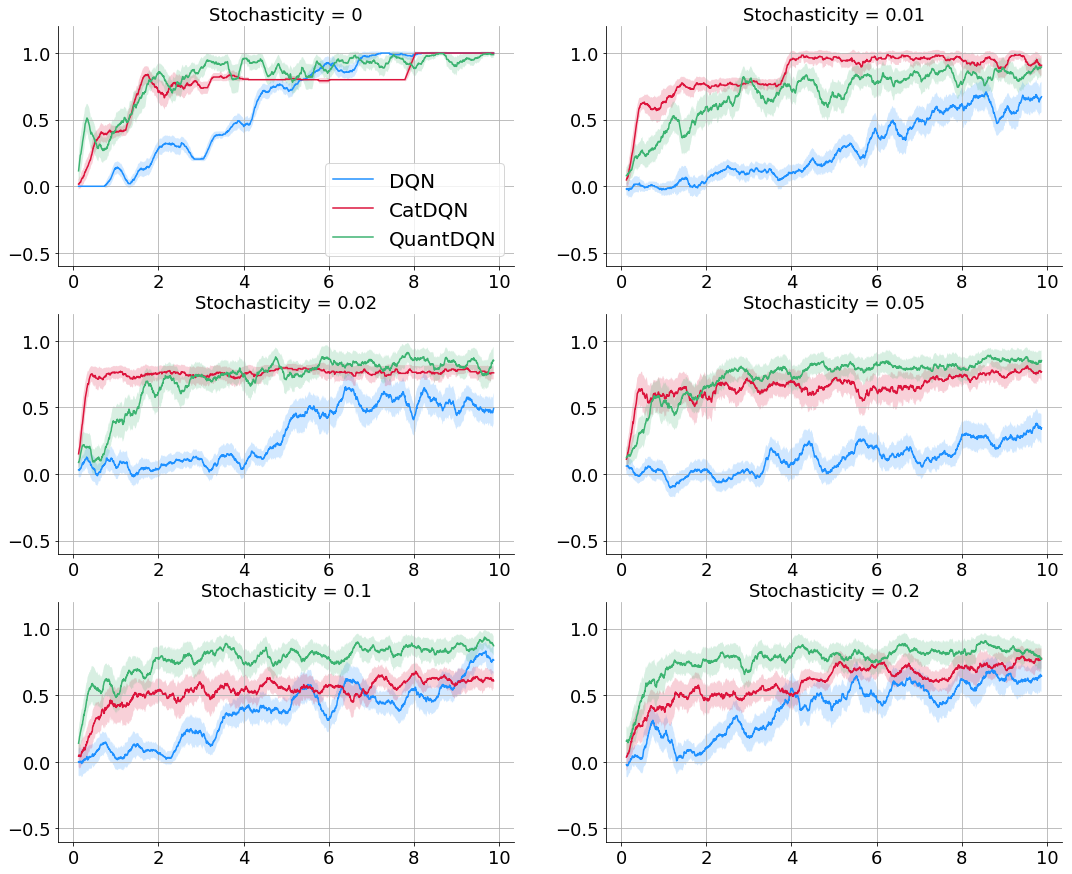

In [6]:
exp_num = 0

paths = [
    "results/031119/exp0_"+str(exp_num)+"/learning_curve.npz",
    "results/031119/exp01_"+str(exp_num)+"/learning_curve.npz",
    "results/031119/exp02_"+str(exp_num)+"/learning_curve.npz",
    "results/031119/exp05_"+str(exp_num)+"/learning_curve.npz",
    "results/031119/exp1_"+str(exp_num)+"/learning_curve.npz",
    "results/031119/exp2_"+str(exp_num)+"/learning_curve.npz"
]
titles = [
    "Stochasticity = 0",
    "Stochasticity = 0.01",
    "Stochasticity = 0.02",
    "Stochasticity = 0.05",
    "Stochasticity = 0.1",
    "Stochasticity = 0.2"
]
colors = ["dodgerblue", "crimson", "mediumseagreen"]
labels = ["DQN", "CatDQN", "QuantDQN"]
tau = 50

plot_everything(paths, titles, colors, labels, tau, save="bs32.png")

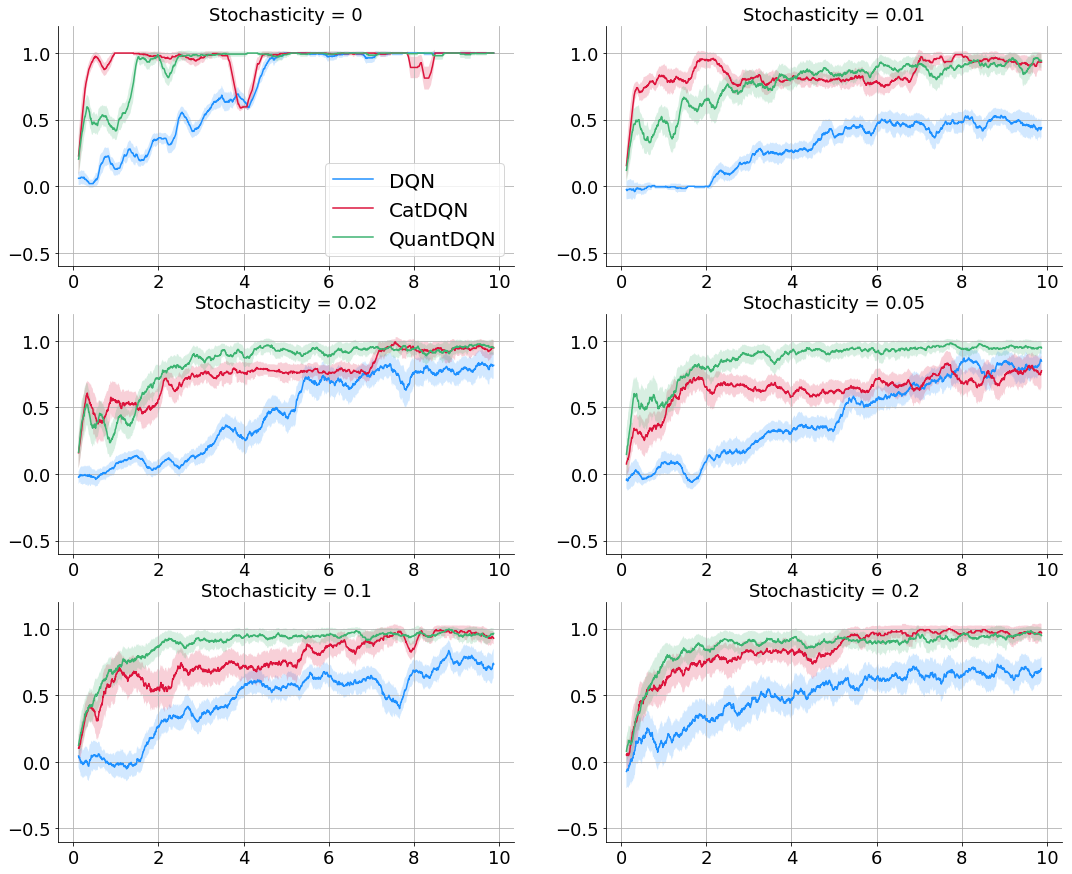

In [7]:
exp_num = 0

paths = [
    "results/031819/exp0_"+str(exp_num)+"/learning_curve.npz",
    "results/031819/exp01_"+str(exp_num)+"/learning_curve.npz",
    "results/031819/exp02_"+str(exp_num)+"/learning_curve.npz",
    "results/031819/exp05_"+str(exp_num)+"/learning_curve.npz",
    "results/031819/exp1_"+str(exp_num)+"/learning_curve.npz",
    "results/031819/exp2_"+str(exp_num)+"/learning_curve.npz"
]
titles = [
    "Stochasticity = 0",
    "Stochasticity = 0.01",
    "Stochasticity = 0.02",
    "Stochasticity = 0.05",
    "Stochasticity = 0.1",
    "Stochasticity = 0.2"
]
colors = ["dodgerblue", "crimson", "mediumseagreen"]
labels = ["DQN", "CatDQN", "QuantDQN"]
tau = 50

plot_everything(paths, titles, colors, labels, tau, save="bs128.png")

# Quantile with various values of kappa

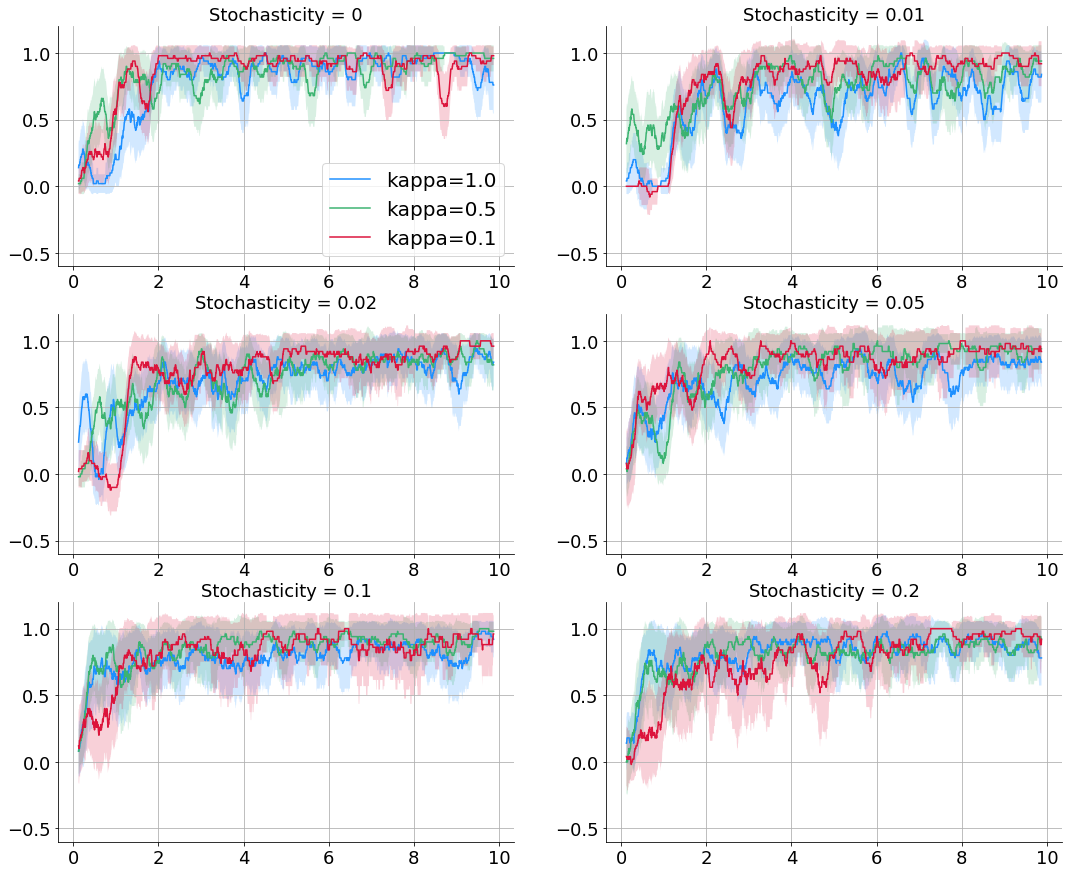

In [11]:
exp_num = 5

paths = [
    "results/031119/quantile/exp0_"+str(exp_num)+"/model/learning_curve.npz",
    "results/031119/quantile/exp01_"+str(exp_num)+"/model/learning_curve.npz",
    "results/031119/quantile/exp02_"+str(exp_num)+"/model/learning_curve.npz",
    "results/031119/quantile/exp05_"+str(exp_num)+"/model/learning_curve.npz",
    "results/031119/quantile/exp1_"+str(exp_num)+"/model/learning_curve.npz",
    "results/031119/quantile/exp2_"+str(exp_num)+"/model/learning_curve.npz"
]

titles = [
    "Stochasticity = 0",
    "Stochasticity = 0.01",
    "Stochasticity = 0.02",
    "Stochasticity = 0.05",
    "Stochasticity = 0.1",
    "Stochasticity = 0.2"
]
colors = ["dodgerblue", "mediumseagreen", "crimson"]
labels = ["kappa=1.0", "kappa=0.5", "kappa=0.1"]
tau = 50

plot_everything(paths, titles, colors, labels, tau)

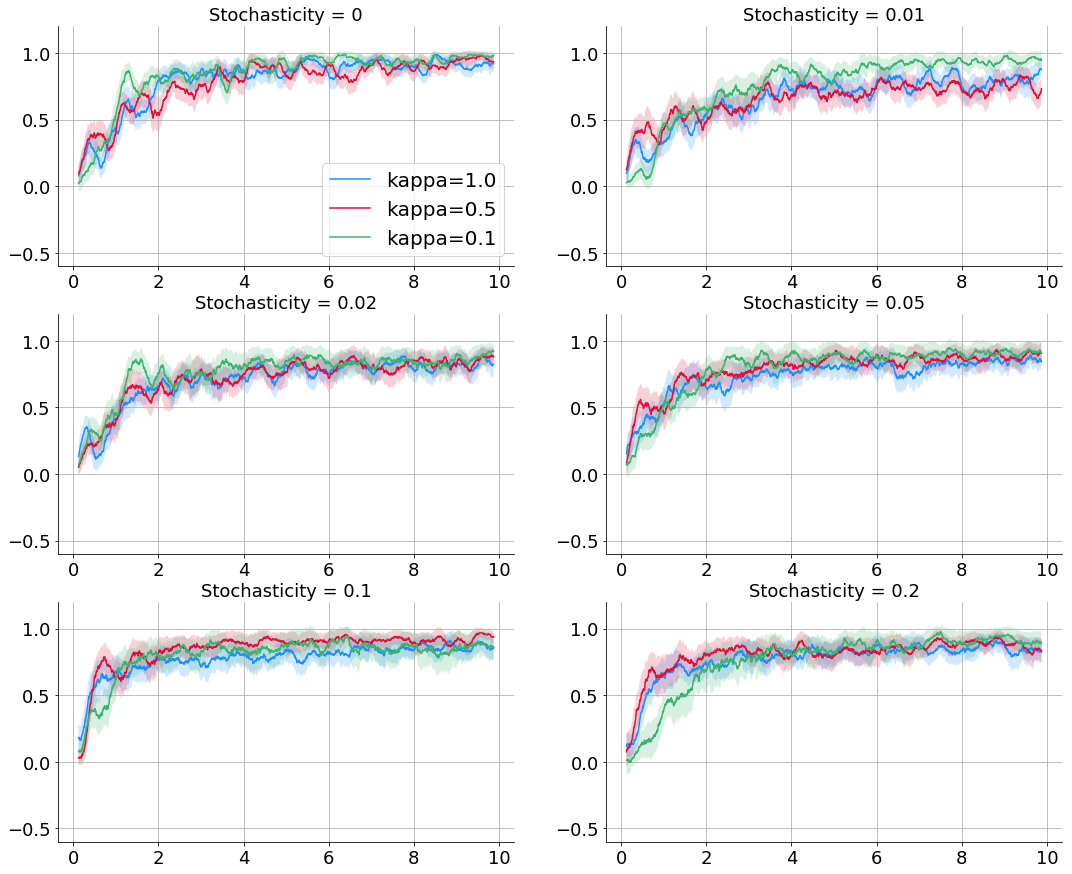

In [15]:
exp_num = 0

paths = [
    "results/031119/quantile/exp0_"+str(exp_num)+"/learning_curve.npz",
    "results/031119/quantile/exp01_"+str(exp_num)+"/learning_curve.npz",
    "results/031119/quantile/exp02_"+str(exp_num)+"/learning_curve.npz",
    "results/031119/quantile/exp05_"+str(exp_num)+"/learning_curve.npz",
    "results/031119/quantile/exp1_"+str(exp_num)+"/learning_curve.npz",
    "results/031119/quantile/exp2_"+str(exp_num)+"/learning_curve.npz"
]
titles = [
    "Stochasticity = 0",
    "Stochasticity = 0.01",
    "Stochasticity = 0.02",
    "Stochasticity = 0.05",
    "Stochasticity = 0.1",
    "Stochasticity = 0.2"
]
colors = ["dodgerblue", "crimson", "mediumseagreen"]
labels = ["kappa=1.0", "kappa=0.5", "kappa=0.1"]
tau = 50

plot_everything(paths, titles, colors, labels, tau, save="quant.png")

IndexError: list index out of range

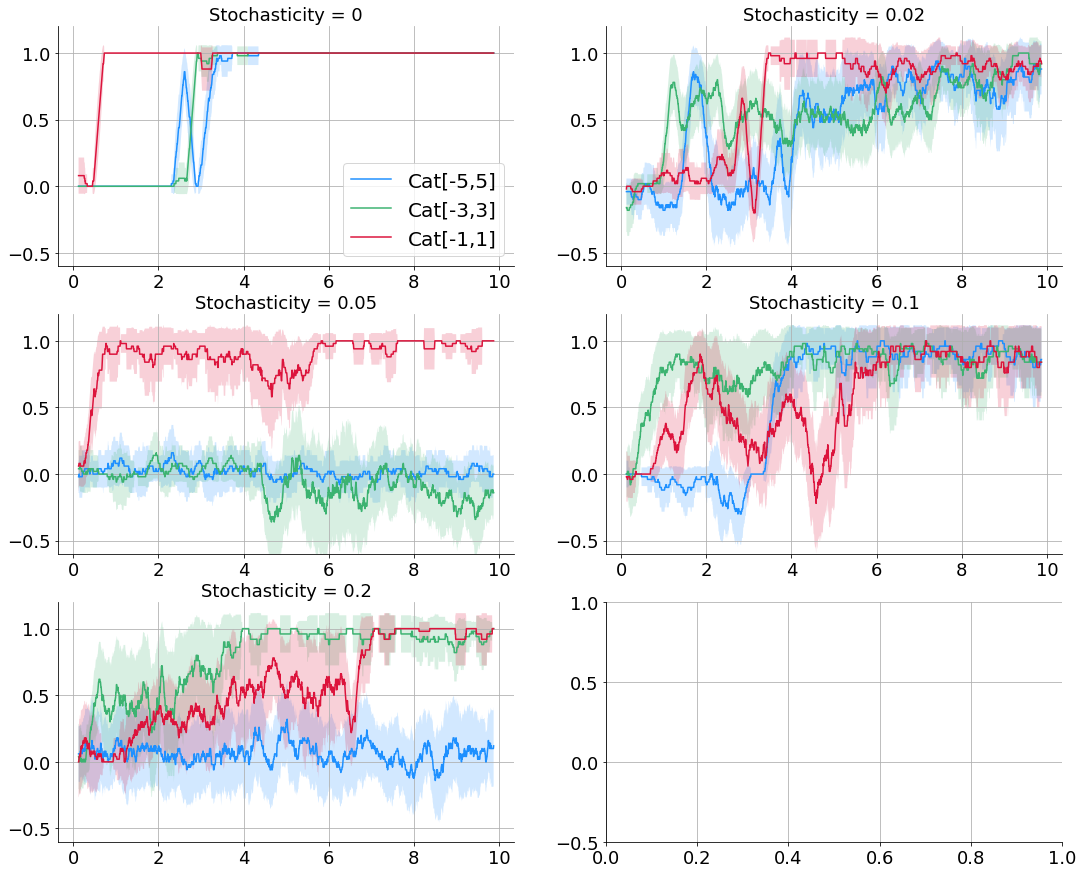

In [19]:
paths = [
    "results/categorical/exp0_2/model/learning_curve.npz",
    "results/categorical/exp02_2/model/learning_curve.npz",
    "results/categorical/exp05_2/model/learning_curve.npz",
    "results/categorical/exp1_2/model/learning_curve.npz",
    "results/categorical/exp2_2/model/learning_curve.npz"
]
titles = [
    "Stochasticity = 0",
    "Stochasticity = 0.02",
    "Stochasticity = 0.05",
    "Stochasticity = 0.1",
    "Stochasticity = 0.2"
]
colors = ["dodgerblue", "mediumseagreen", "crimson"]
labels = ["Cat[-5,5]", "Cat[-3,3]", "Cat[-1,1]"]
tau = 50

plot_everything(paths, titles, colors, labels, tau)

#### Average UNDISCOUNTED return

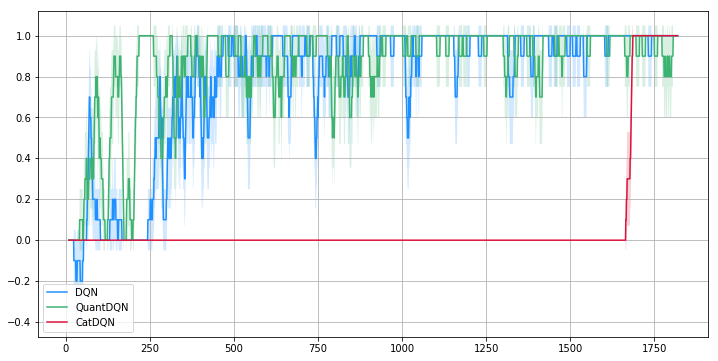

In [3]:
path = "evil_wgw_models/test/exp0_1/model/learning_curve.npz"
test = np.load(path)["test"]
quant, dqn, cat = test[0, :], test[1, :], test[2, :]
plot_two_lines(
    np.arange(len(dqn)),
    ys=[dqn, quant, cat],
    labels=["DQN", "QuantDQN", "CatDQN"],
    colors=["dodgerblue", "mediumseagreen", "crimson"],
    tau=10
)

#### Average number of steps in the episode

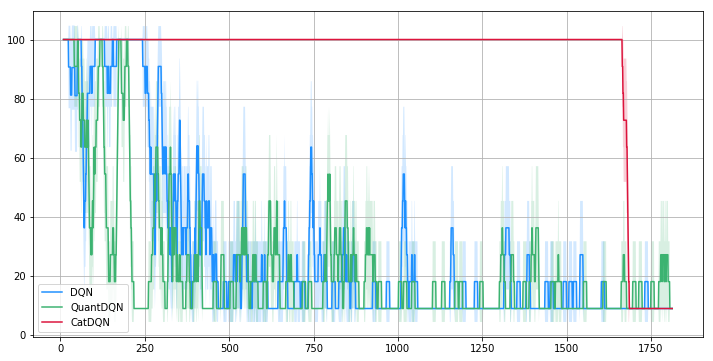

In [7]:
path = "evil_wgw_models/test/exp0_1/model/learning_curve.npz"
test = np.load(path)["test_num_steps"]
quant, dqn, cat = test[0, :], test[1, :], test[2, :]
plot_two_lines(
    np.arange(len(dqn)),
    ys=[dqn, quant, cat],
    labels=["DQN", "QuantDQN", "CatDQN"],
    colors=["dodgerblue", "mediumseagreen", "crimson"],
    tau=10
)

In [25]:
path = "results/031119/exp02_1/model/learning_curve.npz"
q = np.load(path)["q_vals"]
q_dqn, q_cat, q_quant = q[0, -1], q[1, -1], q[2, -1]

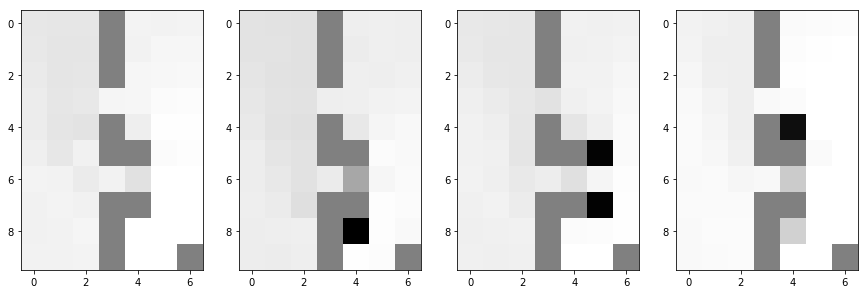

In [26]:
plot_q_values(env, q_dqn)

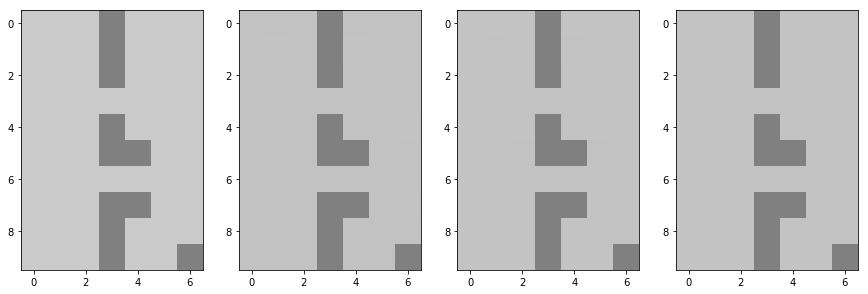

In [27]:
plot_q_values(env, q_cat)

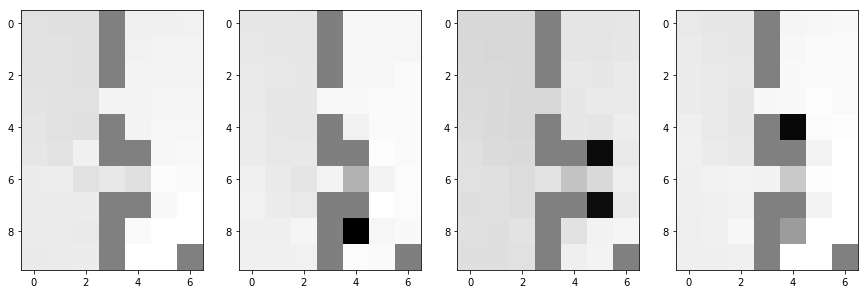

In [28]:
plot_q_values(env, q_quant)

# Categorical

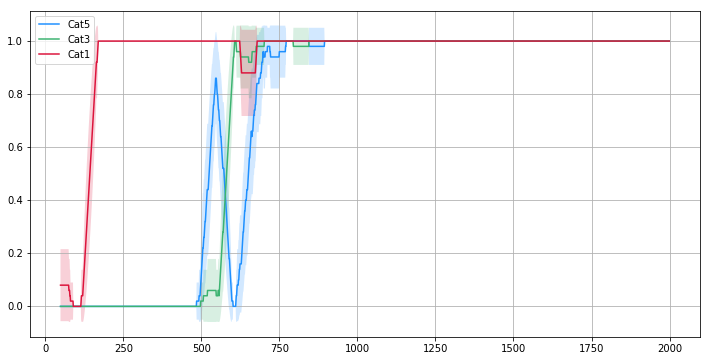

In [32]:
path = "results/categorical/exp0_2/model/learning_curve.npz"
test = np.load(path)["test"]
cat05, cat03, cat01 = test[0, :], test[1, :], test[2, :]
plot_two_lines(
    np.arange(len(cat05)),
    ys=[cat05, cat03, cat01],
    labels=["Cat5", "Cat3", "Cat1"],
    colors=["dodgerblue", "mediumseagreen", "crimson"],
    tau=50
)

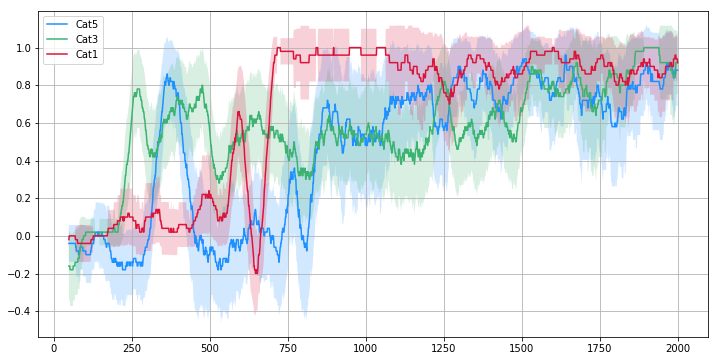

In [33]:
path = "results/categorical/exp02_2/model/learning_curve.npz"
test = np.load(path)["test"]
cat05, cat03, cat01 = test[0, :], test[1, :], test[2, :]
plot_two_lines(
    np.arange(len(cat05)),
    ys=[cat05, cat03, cat01],
    labels=["Cat5", "Cat3", "Cat1"],
    colors=["dodgerblue", "mediumseagreen", "crimson"],
    tau=50
)

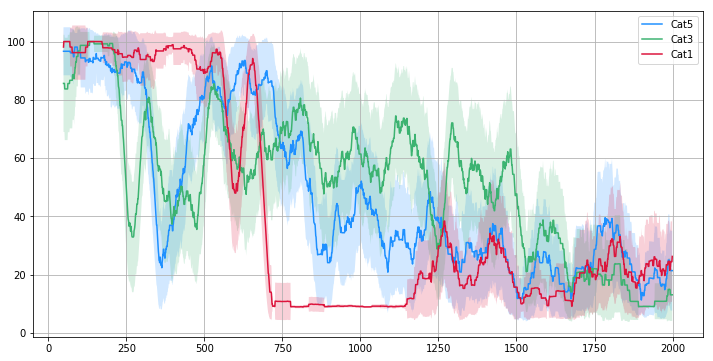

In [34]:
path = "results/categorical/exp02_2/model/learning_curve.npz"
test = np.load(path)["test_num_steps"]
cat05, cat03, cat01 = test[0, :], test[1, :], test[2, :]
plot_two_lines(
    np.arange(len(cat05)),
    ys=[cat05, cat03, cat01],
    labels=["Cat5", "Cat3", "Cat1"],
    colors=["dodgerblue", "mediumseagreen", "crimson"],
    tau=50
)

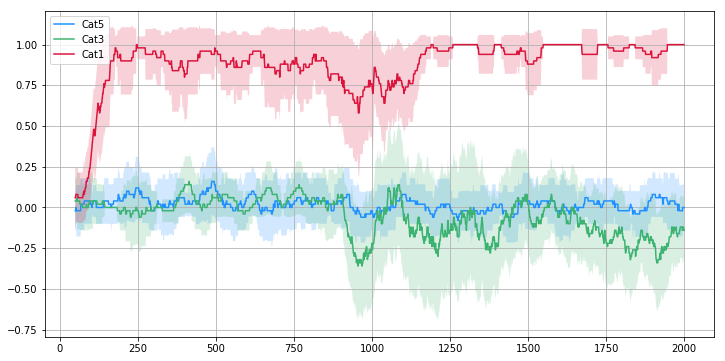

In [38]:
path = "results/categorical/exp05_2/model/learning_curve.npz"
test = np.load(path)["test"]
cat05, cat03, cat01 = test[0, :], test[1, :], test[2, :]
plot_two_lines(
    np.arange(len(cat05)),
    ys=[cat05, cat03, cat01],
    labels=["Cat5", "Cat3", "Cat1"],
    colors=["dodgerblue", "mediumseagreen", "crimson"],
    tau=50
)

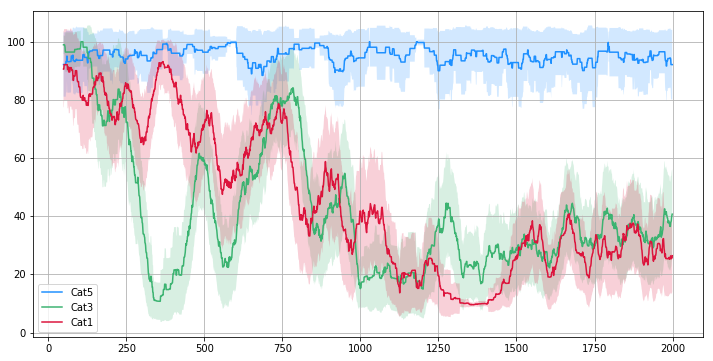

In [17]:
path = "results/categorical/exp05_1/model/learning_curve.npz"
test = np.load(path)["test_num_steps"]
cat05, cat03, cat01 = test[0, :], test[1, :], test[2, :]
plot_two_lines(
    np.arange(len(cat05)),
    ys=[cat05, cat03, cat01],
    labels=["Cat5", "Cat3", "Cat1"],
    colors=["dodgerblue", "mediumseagreen", "crimson"],
    tau=50
)

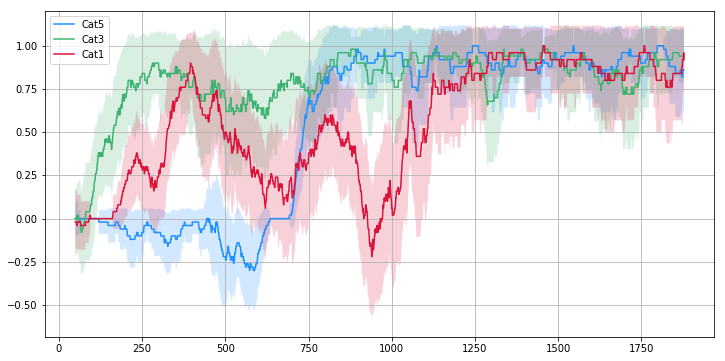

In [39]:
path = "results/categorical/exp1_2/model/learning_curve.npz"
test = np.load(path)["test"]
cat05, cat03, cat01 = test[0, :], test[1, :], test[2, :]
plot_two_lines(
    np.arange(len(cat05)),
    ys=[cat05, cat03, cat01],
    labels=["Cat5", "Cat3", "Cat1"],
    colors=["dodgerblue", "mediumseagreen", "crimson"],
    tau=50
)

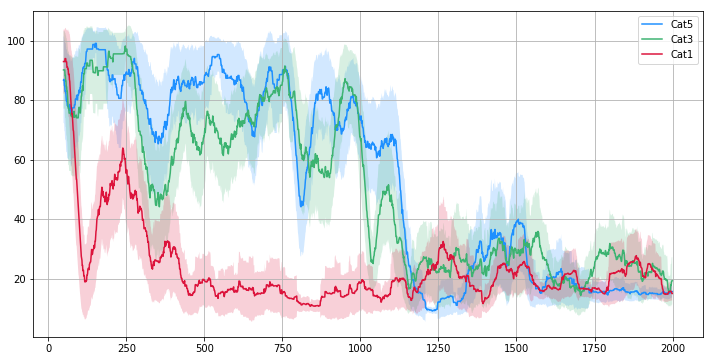

In [30]:
path = "results/categorical/exp1_1/model/learning_curve.npz"
test = np.load(path)["test_num_steps"]
cat05, cat03, cat01 = test[0, :], test[1, :], test[2, :]
plot_two_lines(
    np.arange(len(cat05)),
    ys=[cat05, cat03, cat01],
    labels=["Cat5", "Cat3", "Cat1"],
    colors=["dodgerblue", "mediumseagreen", "crimson"],
    tau=50
)

In [22]:
path = "results/categorical/exp1_1/model/learning_curve.npz"
q = np.load(path)["q_vals"]
q5, q3, q1 = q[0, -1], q[1, -1], q[2, -1]

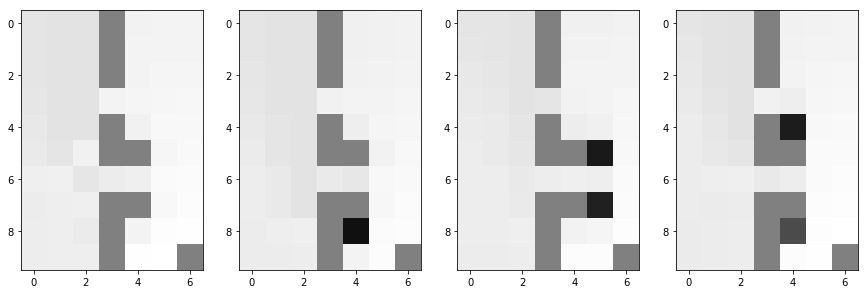

In [23]:
plot_q_values(env, q5)

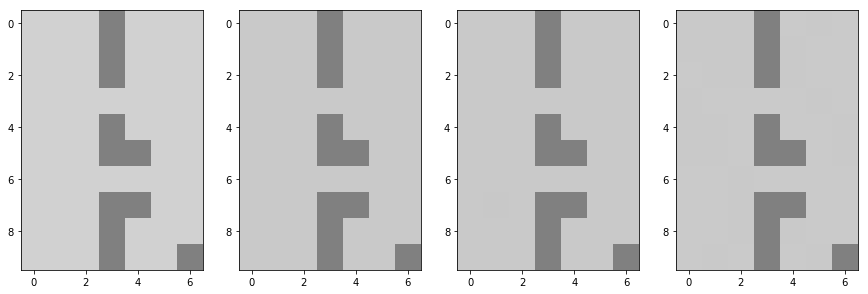

In [20]:
plot_q_values(env, q3)

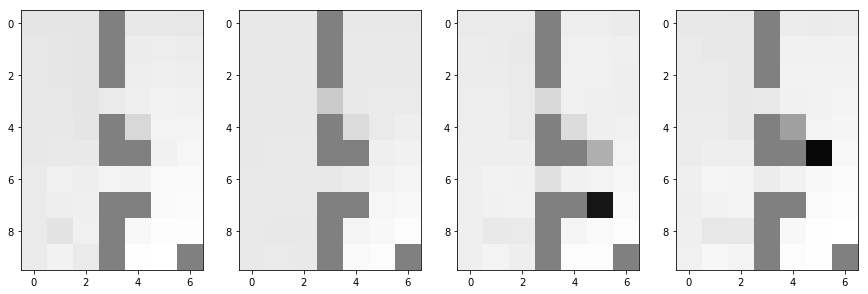

In [21]:
plot_q_values(env, q1)

# Dev

In [ ]:
def q_table2q_values(env, q_table):
    q_values = np.zeros((59, 4))

    idx = 0
    for i in range(env.w):
        for j in range(env.h):
            valid, s = env.set_pos((i, j))
            if valid:
                q_values[idx] = q_table[i, j]
                idx += 1
    return q_values

stocs = [0, 0.01, 0.02, 0.05, 0.1, 0.2]
files = ["0", "01", "02", "05", "1", "2"]

for i in range(6):

    env = EvilWindyGridWorld(
        grid_size=(7, 10), visual=True, stochasticity=stocs[i])
    num_actions = 4

    qt = QTable(env)
    qt.run_policy_iteration(pol_eval_times=1, tol=1e-5)
    true_q_vals = q_table2q_values(env, qt.q)

    data = np.load("results/031119/exp%s_3/model/learning_curve.npz" % files[i])

    rewards = np.zeros((3, 2000))
    for j in range(3):
        q = data["q_vals"][j]
        pol = np.argmax(q, axis=-1)
        stats = (pol == np.argmax(true_q_vals, axis=-1)[None, :]).sum(axis=1)
        rewards[j] = stats
        
    np.savez("results/031119/exp%s_3/model/policy_hits.npz" % files[i], test=rewards)